In [121]:
import sys
sys.path.append("..")
from utils import load_data
from train import train_gfnn, test_regression
import torch
import torch.nn as nn
from torch.nn import Module
import torch.nn.functional as F
import math
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
import numpy as np
import networkx as nx
from matplotlib import pyplot as plt
import seaborn as sns

In [463]:
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier

In [2]:
class MLP(Module):
    def __init__(self, nfeat, nhid, nclass, dp=0.2):
        super(MLP, self).__init__()
        self.W1 = nn.Linear(nfeat, nhid)
        self.W2 = nn.Linear(nhid, nclass)
        self.dp = dp
        self.act = nn.PReLU()
        self.num_class = nclass

    def forward(self, x):
        x = self.act(self.W1(x))
        x = nn.Dropout(p=self.dp)(x)
        return self.W2(x)

In [111]:
def rayleigh_i(X, M, index=0):
    r = X[:,index].unsqueeze(0) @ torch.spmm(M, X[:,index].unsqueeze(1))
    d = torch.norm(X[:,index], p=2).item()**2
    if d == 0.0:
        return 0
    return r.item() / d

In [125]:
def feature_transform(adj, X, k=1):
    for i in range(k):
        X = torch.spmm(adj, X)
    return X

In [214]:
def fourier_filter(U, X, indices=(0,100)):
    i, j = indices
    coeff = U[:,i:j].transpose(0,1) @ X
    X_hat = U[:,i:j] @ coeff
    return X_hat

# Cora

### A. Matching Rayleigh Quotient

In [3]:
gnx, normed_adj, X, y, idx_train, idx_val, idx_test = \
            load_data("cora", ['', "RwNorm", "SymNormLap", "AbsRwNormAdj"])

In [80]:
yoh = F.one_hot(y, num_classes=7).float()

In [131]:
labels_r = np.array([rayleigh_i(yoh, normed_adj[2], i) for i in range(7)])
print("Mean: {}, Std: {}".format(labels_r.mean(), labels_r.std()))

Mean: 0.2971457486046264, Std: 0.04741947745730274


In [462]:
labels_r

array([0.35705904, 0.37151298, 0.2464746 , 0.27849939, 0.23773519,
       0.3033104 , 0.28542863])

In [128]:
X_r = np.array([rayleigh_i(X, normed_adj[2], i) for i in range(1433)])
print("Mean: {}, Std: {}".format(X_r.mean(), X_r.std()))

Mean: 0.9148640377044285, Std: 0.10261153153787544


In [129]:
X_RwNorm = feature_transform(normed_adj[1], X, k=1)
X_RwNorm_r = np.array([rayleigh_i(X_RwNorm, normed_adj[2], i) for i in range(1433)])
print("Mean: {}, Std: {}".format(X_RwNorm_r.mean(), X_RwNorm_r.std()))

Mean: 0.47614158213978974, Std: 0.13366578499985574


In [410]:
X_RwNorm_r = np.array([rayleigh_i(X_RwNorm, normed_adj[1], i) for i in range(1433)])
print("Mean: {}, Std: {}".format(X_RwNorm_r.mean(), X_RwNorm_r.std()))

Mean: 0.8537323202344138, Std: 0.06531045819977545


In [132]:
X_AbsRwNormAdj = feature_transform(normed_adj[3], X, k=1)
X_AbsRwNormAdj_r = np.array([rayleigh_i(X_AbsRwNormAdj, normed_adj[2], i) for i in range(1433)])
print("Mean: {}, Std: {}".format(X_AbsRwNormAdj_r.mean(), X_AbsRwNormAdj_r.std()))

Mean: 0.47614158213978974, Std: 0.13366578499985574


In [133]:
X_RwNorm = feature_transform(normed_adj[1], X, k=2)
X_RwNorm_r = np.array([rayleigh_i(X_RwNorm, normed_adj[2], i) for i in range(1433)])
print("Mean: {}, Std: {}".format(X_RwNorm_r.mean(), X_RwNorm_r.std()))

Mean: 0.29078903412235574, Std: 0.10440063335192415


Note: The filter makes the feature matches the rayleight quotient of the labels 

### B.  Eigendecomposition

In [152]:
nx.number_connected_components(gnx)

78

In [441]:
l, v = np.linalg.eigh(nx.normalized_laplacian_matrix(gnx).A + 0.0001)
l[np.where(l < 1e-10)] = 0
idx = l.argsort()   
l = l[idx]
v = v[:,idx]

In [442]:
v = torch.Tensor(v).float()

In [443]:
rayleigh_i(v, normed_adj[2], 2000)

1.407133133061216

In [444]:
l.max()

2.0000316592388208

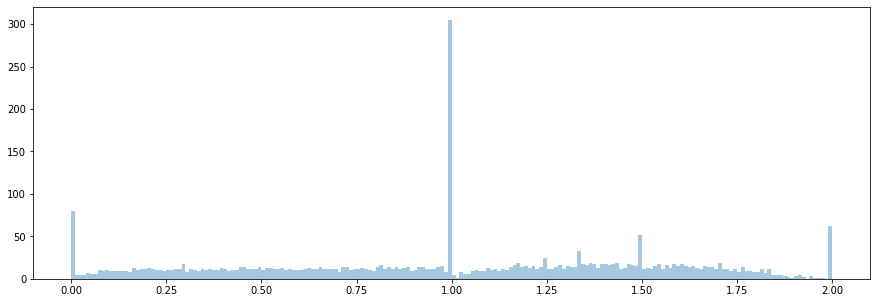

In [451]:
plt.figure(figsize=(15,5))
sns.distplot(l, bins=200, kde=False, rug=False)

In [460]:
clf = SGDClassifier(max_iter=20000, tol=1e-2)
feat = fourier_filter(v, X, indices=(0, 450))
train_feat = feat[idx_train].numpy()
val_feat = feat[idx_val].numpy()
test_feat = feat[idx_test].numpy()

clf.fit(train_feat, y[idx_train])

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=20000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.01,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [461]:
np.sum(clf.predict(test_feat) == y[idx_test].numpy()) / 1000

0.738

Fit random features

In [432]:
with torch.no_grad():
    rand_yoh = torch.zeros_like(yoh)
    for i in range(len(rand_yoh)):
        j = np.random.randint(0,7)
        rand_yoh[j] = 1

In [433]:
rand_labels_r = np.array([rayleigh_i(rand_yoh, normed_adj[2], i) for i in range(7)])
print("Mean: {}, Std: {}".format(rand_labels_r.mean(), rand_labels_r.std()))

Mean: 0.9262289832206402, Std: 1.1102230246251565e-16


In [488]:
rayleigh_i(v, normed_adj[2], 1000)

0.858216218097742

In [489]:
rayleigh_i(v, normed_adj[2], 1200)

0.9999996423722024

In [464]:
rand_y = np.array([np.random.randint(0,7) for _ in range(len(rand_yoh))])

In [486]:
clf = MLPClassifier(hidden_layer_sizes=(50,30), max_iter=2000)
feat = fourier_filter(v, X, indices=(1000, 1200))
train_feat = feat[idx_train].numpy()
val_feat = feat[idx_val].numpy()
test_feat = feat[idx_test].numpy()

clf.fit(train_feat, rand_y[idx_train])

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(50, 30), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=2000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [487]:
np.sum(clf.predict(train_feat) == rand_y[idx_train]) / 1000

0.129

In [483]:
rayleigh_i(v, normed_adj[2], 1000)

0.858216218097742

# Citeseer

### A. Matching Rayleigh quotient

In [530]:
gnx, normed_adj, X, y, idx_train, idx_val, idx_test = \
            load_data("citeseer", ['', "RwNorm", "SymNormLap", "AbsRwNormAdj"])

../normalization.py:79: RuntimeWarning: divide by zero encountered in power
  r_inv = np.power(rowsum, -1).flatten()


In [531]:
yoh = F.one_hot(y, num_classes=6).float()

In [532]:
labels_r = np.array([rayleigh_i(yoh, normed_adj[2], i) for i in range(6)])
print("Mean: {}, Std: {}".format(labels_r.mean(), labels_r.std()))

Mean: 0.37658795671073975, Std: 0.11117576443748893


In [533]:
labels_r

array([0.60458063, 0.37608983, 0.39446794, 0.28630787, 0.32804129,
       0.27004017])

In [534]:
X_r = np.array([rayleigh_i(X, normed_adj[2], i) for i in range(3703)])
print("Mean: {}, Std: {}".format(X_r.mean(), X_r.std()))

Mean: 0.8055648380693111, Std: 0.19417330372665548


In [535]:
X_RwNorm = feature_transform(normed_adj[1], X, k=1)
X_RwNorm_r = np.array([rayleigh_i(X_RwNorm, normed_adj[2], i) for i in range(3703)])
print("Mean: {}, Std: {}".format(X_RwNorm_r.mean(), X_RwNorm_r.std()))

Mean: 0.32037138477031735, Std: 0.13754224668649165


In [536]:
X_RwNorm = feature_transform(normed_adj[1], X, k=2)
X_RwNorm_r = np.array([rayleigh_i(X_RwNorm, normed_adj[2], i) for i in range(3703)])
print("Mean: {}, Std: {}".format(X_RwNorm_r.mean(), X_RwNorm_r.std()))

Mean: 0.17920855110772774, Std: 0.09094552240239674


### B. Eigendecomposition

In [537]:
nx.number_connected_components(gnx)

438

In [538]:
l, v = np.linalg.eigh(nx.normalized_laplacian_matrix(gnx).A + 0.0001)
l[np.where(l < 1e-10)] = 0
idx = l.argsort()   
l = l[idx]
v = v[:,idx]

In [545]:
v = torch.Tensor(v).float()
rayleigh_i(v, normed_adj[2], 1000)

0.5114935520000037

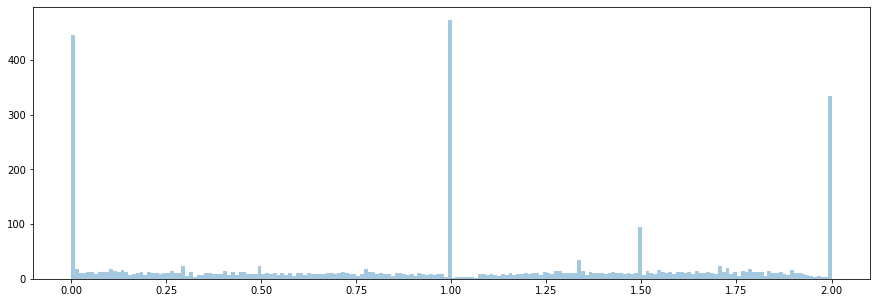

In [546]:
plt.figure(figsize=(15,5))
sns.distplot(l, bins=200, kde=False, rug=False)

# Pubmed

### A. Matching Rayleigh quotient

In [515]:
gnx, normed_adj, X, y, idx_train, idx_val, idx_test = \
            load_data("pubmed", ['', "RwNorm", "SymNormLap", "AbsRwNormAdj"])

In [517]:
yoh = F.one_hot(y, num_classes=6).float()
labels_r = np.array([rayleigh_i(yoh, normed_adj[2], i) for i in range(6)])
print("Mean: {}, Std: {}".format(labels_r.mean(), labels_r.std()))

Mean: 0.2543236723254429, Std: 0.2554629888099532


In [518]:
X_r = np.array([rayleigh_i(X, normed_adj[2], i) for i in range(500)])
print("Mean: {}, Std: {}".format(X_r.mean(), X_r.std()))

Mean: 0.8671004615600176, Std: 0.07000272088299465


In [520]:
X_RwNorm = feature_transform(normed_adj[1], X, k=1)
X_RwNorm_r = np.array([rayleigh_i(X_RwNorm, normed_adj[2], i) for i in range(500)])
print("Mean: {}, Std: {}".format(X_RwNorm_r.mean(), X_RwNorm_r.std()))

Mean: 0.6916697668831758, Std: 0.07310921154793198


In [522]:
X_RwNorm = feature_transform(normed_adj[1], X, k=2)
X_RwNorm_r = np.array([rayleigh_i(X_RwNorm, normed_adj[2], i) for i in range(500)])
print("Mean: {}, Std: {}".format(X_RwNorm_r.mean(), X_RwNorm_r.std()))

Mean: 0.4986617145943691, Std: 0.04280482903423631


In [529]:
X_RwNorm = feature_transform(normed_adj[1], X, k=40)
X_RwNorm_r = np.array([rayleigh_i(X_RwNorm, normed_adj[2], i) for i in range(500)])
print("Mean: {}, Std: {}".format(X_RwNorm_r.mean(), X_RwNorm_r.std()))

Mean: 0.3719364095902638, Std: 0.015110402967608908
